## Token Position Structure in Gemma 3 Vision Tokens

Gemma 3 encodes images as 256 "soft tokens" that are fed to the language model.

**Research question:** Is there any interpretable structure in how information is distributed across the 256 soft token positions?

In [1]:
import duckdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sns.set_theme(style="dark", font="JetBrains Mono")
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 14
PAD = 25

In [2]:
conn = duckdb.connect("open_images/open_images_embeddings.db")

### Compute Pairwise Similarity Within Images

For each image, we compute a 256x256 matrix where entry (i, j) is the cosine similarity between token i and token j.

This captures the "representational geometry" of each image - how similar are different positions to each other?

In [3]:
def get_similarity_matrix(image_id: str, conn) -> np.ndarray:
    """Compute pairwise cosine similarity between all token positions for one image."""

    df = conn.sql(f"""
        SELECT token_position, embedding_vector 
        FROM image_token_embeddings 
        WHERE image_id = '{image_id}'
        ORDER BY token_position
    """).df()

    embeddings = np.stack(df["embedding_vector"].values)
    return cosine_similarity(embeddings, embeddings)


def get_all_similarity_matrices(conn) -> np.ndarray:
    """Compute similarity matrices for all images. Returns tensor of shape (n_images, 256, 256)."""

    image_ids = (
        conn.sql("""
        SELECT DISTINCT image_id
        FROM image_token_embeddings
        ORDER BY image_id
    """)
        .df()
        .image_id.to_list()
    )

    return np.stack([get_similarity_matrix(img_id, conn) for img_id in image_ids])

In [4]:
# This takes a minute and ~40GB RAM for 10K images
similarity_tensor = get_all_similarity_matrices(conn)
similarity_tensor.shape

(10000, 256, 256)

### Average Similarity Matrix

By averaging the similarity matrices across all images, structure that is consistent regardless of image content should emerge.

If positions encode content-specific information, averaging would wash out to uniform similarity. If positions have consistent roles, patterns will appear.

This approach is loosely inspired by the little I know about Representational Similarity Analysis (RSA). 

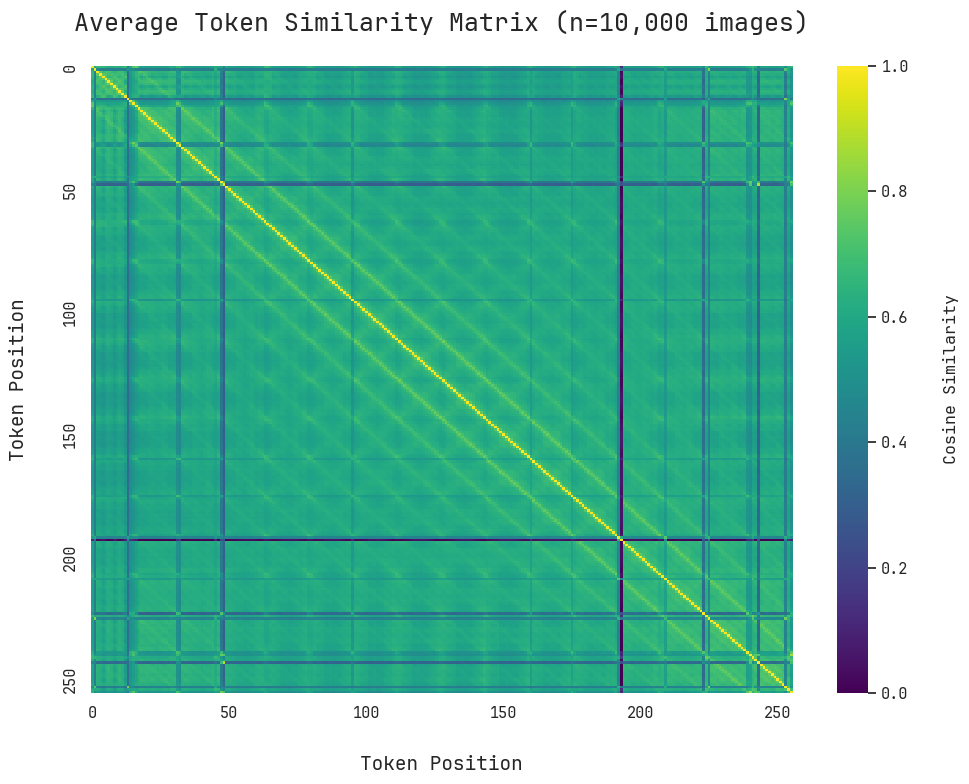

In [5]:
avg_similarity = similarity_tensor.mean(axis=0)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    avg_similarity,
    cmap="viridis",
    xticklabels=50,
    yticklabels=50,
    vmax=1,
    vmin=0,
    cbar_kws={"label": "Cosine Similarity"},
)
plt.title(
    "Average Token Similarity Matrix (n=10,000 images)",
    fontsize=TITLE_FONTSIZE,
    pad=PAD,
)
plt.xlabel("Token Position", fontsize=LABEL_FONTSIZE, labelpad=PAD)
plt.ylabel("Token Position", fontsize=LABEL_FONTSIZE, labelpad=PAD)
ax.collections[0].colorbar.ax.yaxis.labelpad = PAD
plt.tight_layout()

#### Which position is most dissimilar?

For each position, compute its mean similarity to all other positions.

Most dissimilar position = 193: 0.046


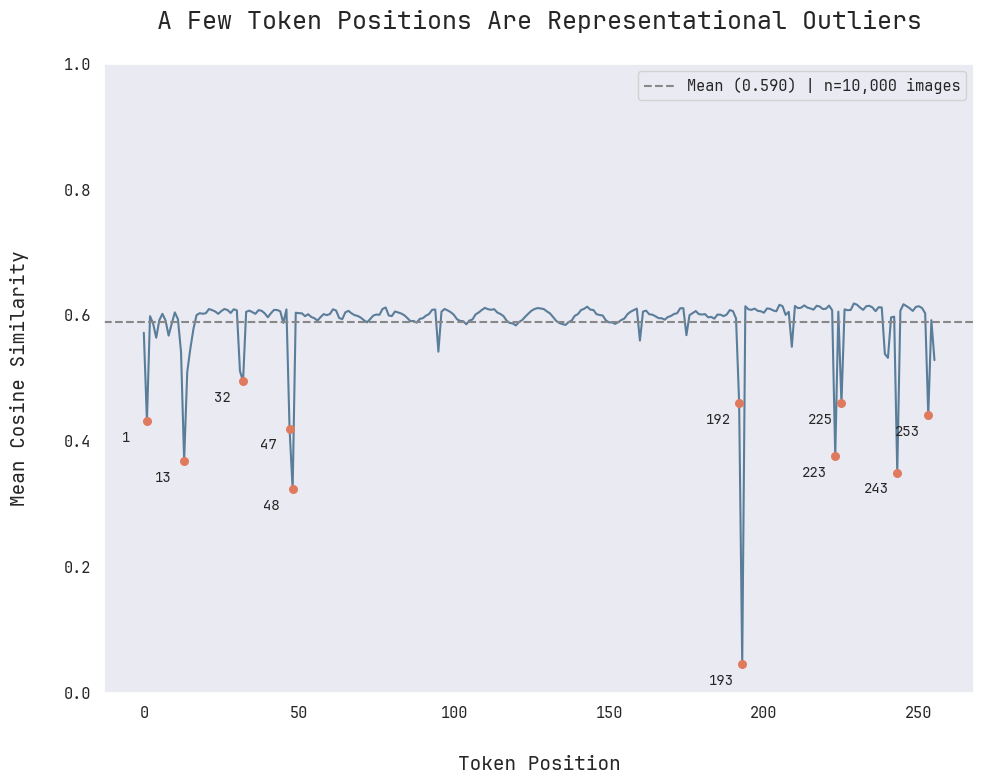

In [6]:
mean_similarity_per_position = avg_similarity.mean(axis=0)

# Threshold to label the obvious dips
outlier_threshold = 0.5
outlier_positions = np.where(mean_similarity_per_position < outlier_threshold)[0]

plt.figure(figsize=(10, 8))
plt.plot(mean_similarity_per_position, color="#5a7d9a")
plt.scatter(
    outlier_positions,
    mean_similarity_per_position[outlier_positions],
    color="#e07a5f",
    s=30,
    zorder=5,
)
for pos in outlier_positions:
    plt.annotate(
        str(pos),
        (pos, mean_similarity_per_position[pos]),
        textcoords="offset points",
        xytext=(-15, -15),
        ha="center",
        fontsize=10,
    )
plt.axhline(
    y=mean_similarity_per_position.mean(),
    color="#888888",
    linestyle="--",
    label=f"Mean ({mean_similarity_per_position.mean():.3f}) | n=10,000 images",
)
plt.title(
    "A Few Token Positions Are Representational Outliers",
    fontsize=TITLE_FONTSIZE,
    pad=PAD,
)
plt.xlabel("Token Position", fontsize=LABEL_FONTSIZE, labelpad=PAD)
plt.ylabel("Mean Cosine Similarity", fontsize=LABEL_FONTSIZE, labelpad=PAD)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()

most_dissimilar = np.argmin(mean_similarity_per_position)
print(
    f"Most dissimilar position = {most_dissimilar}: {mean_similarity_per_position[most_dissimilar]:.3f}"
)